In [1]:
import pandas as pd
import os

path = os.path.abspath(os.path.join(os.path.dirname('__file__'),'ml-latest-small'))
ratings = pd.read_csv(path + '/ratings.csv')
# movies_name = pd.read_csv(path + '/movies.csv').set_index('movieId')['title'].to_dict()

# user and movie, unique means group
users = ratings.userId.unique()
movies = ratings.movieId.unique()

# userid2idx, ubah id user dan movie
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])
ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])

### csv dalam bentuk pandas(awal)

In [61]:
# sebelum id diubah
print(ratings.head())

   userId  movieId  rating  timestamp
0       0        0     4.0  964982703
1       0        1     4.0  964981247
2       0        2     4.0  964982224
3       0        3     5.0  964983815
4       0        4     5.0  964982931


### Userid dan movieid yang sudah di ubah nilainya

In [52]:
# setelah id diubah
print(ratings.head())

   userId  movieId  rating  timestamp
0       0        0     4.0  964982703
1       0        1     4.0  964981247
2       0        2     4.0  964982224
3       0        3     5.0  964983815
4       0        4     5.0  964982931


### Filter Top Users and Movies

In [2]:
# filtering top user and top movie
group_user = ratings.groupby('userId')['rating'].count()
topUser = group_user.sort_values(ascending=False)[:30]

group_movie = ratings.groupby('movieId')['rating'].count()
topMovie = group_movie.sort_values(ascending=False)[:30]
print(topMovie.head())

movieId
20     329
232    317
16     307
34     279
166    278
Name: rating, dtype: int64


In [3]:
import numpy as np

top_r = ratings.join(topUser, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(topMovie, rsuffix='_r', how='inner', on='movieId')
print(top_r.head())

       userId  movieId  rating   timestamp  rating_r  rating_r
2274       18        0     4.0   965705637       703       215
10360      67        0     2.5  1158531426      1260       215
24900     176        0     5.0  1435533535       904       215
26092     181        0     4.0  1063289621       977       215
33898     231        0     3.5  1076955621       862       215


In [4]:
# index-> movieId
a = pd.crosstab(top_r.userId, top_r.movieId, values=top_r.rating, aggfunc=np.sum)#, top_r.rating, aggfunc=np.sum

In [7]:
print(a)

movieId  0     3     4     7     15    16    20    25    26    28    ...   \
userId                                                               ...    
18        4.0   3.0   NaN   NaN   4.0   NaN   2.0   4.0   2.0   NaN  ...    
67        2.5   4.0   3.0   2.5   5.0   2.0   3.5   4.5   3.5   4.0  ...    
104       NaN   5.0   5.0   3.5   4.0   5.0   3.5   NaN   NaN   3.5  ...    
110       NaN   NaN   NaN   NaN   NaN   NaN   5.0   NaN   2.5   NaN  ...    
176       5.0   4.5   4.0   NaN   2.5   5.0   5.0   NaN   3.5   4.5  ...    
181       4.0   4.0   4.5   3.5   3.5   5.0   5.0   3.5   3.5   4.0  ...    
231       3.5   4.5   NaN   4.5   4.5   5.0   4.0   NaN   3.0   4.5  ...    
248       4.0   5.0   4.0   5.0   5.0   4.0   4.5   4.5   4.0   4.5  ...    
273       4.0   4.0   4.0   4.5   3.0   5.0   4.5   3.5   3.5   4.0  ...    
287       4.5   3.5   NaN   5.0   5.0   5.0   5.0   3.0   2.0   5.0  ...    
297       2.0   4.0   3.5   3.0   4.0   4.5   3.0   NaN   4.0   NaN  ...    

### Embedding Process

In [5]:
from keras.layers import Input, Embedding, concatenate, Flatten, Dropout, Dense

n_users = ratings.userId.nunique() # len(n_users)
n_movies = ratings.movieId.nunique()
n_factors = 10
print(n_users,n_movies)

user_in = Input(shape=(1,),dtype='int64',name='user_in')
u = Embedding(n_users, n_factors, input_length=1)(user_in)
movie_in = Input(shape=(1,),dtype='int64',name='movie_in')
m = Embedding(n_movies, n_factors, input_length=1)(movie_in)
print(u)

Using TensorFlow backend.


610 9724
Tensor("embedding_1/embedding_lookup:0", shape=(?, 1, 10), dtype=float32)


### Model Keras


In [10]:
from keras.models import Model

x = concatenate([u, m], axis=-1)
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(64,activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64,activation='elu')(x)
x = Dropout(0.3)(x)
x = Dense(1)(x) # karena Y tidak dalam bentuk one-hot-metrics
nn = Model([user_in, movie_in],x)
nn.compile(optimizer='Adam', loss='mse', metrics=['accuracy'])

# execute
# nn.fit([top_r.userId, top_r.movieId], top_r.rating, batch_size= 32, epochs = 30, validation_split= 0.1)
nn.fit([ratings.userId, ratings.movieId], ratings.rating, batch_size= 32, epochs = 10, validation_split= 0.1)

Train on 90752 samples, validate on 10084 samples
Epoch 1/10
90752/90752 [==============================] - 13s 145us/step - loss: 1.1276 - acc: 0.2677 - val_loss: 0.9023 - val_acc: 0.2513
Epoch 2/10
90752/90752 [==============================] - 13s 144us/step - loss: 0.8475 - acc: 0.2976 - val_loss: 0.8758 - val_acc: 0.2612
Epoch 3/10
90752/90752 [==============================] - 15s 168us/step - loss: 0.7959 - acc: 0.3076 - val_loss: 0.8650 - val_acc: 0.2641
Epoch 4/10
90752/90752 [==============================] - 16s 172us/step - loss: 0.7621 - acc: 0.3190 - val_loss: 0.8762 - val_acc: 0.2603
Epoch 5/10
90752/90752 [==============================] - 16s 172us/step - loss: 0.7373 - acc: 0.3220 - val_loss: 0.8486 - val_acc: 0.2608
Epoch 6/10
90752/90752 [==============================] - 16s 172us/step - loss: 0.7187 - acc: 0.3282 - val_loss: 0.8631 - val_acc: 0.2644
Epoch 7/10
90752/90752 [==============================] - 16s 177us/step - loss: 0.7036 - acc: 0.3325 - val_loss: 0.

In [11]:
pred = nn.predict([ratings.userId[231:240], ratings.movieId[231:241]])
print(pred)

[[4.380364 ]
 [4.2709303]
 [3.7900486]
 [4.0209913]
 [3.949606 ]
 [3.9218256]
 [3.6410048]
 [3.3155937]
 [4.109418 ]]


In [12]:
print(ratings[231:241])

     userId  movieId  rating   timestamp
231       0      231     5.0   964984002
232       1      232     3.0  1445714835
233       1       18     4.0  1445715029
234       1      233     4.5  1445715228
235       1      219     4.0  1445714885
236       1      234     4.0  1445714952
237       1      235     3.5  1445714960
238       1      236     4.0  1445715013
239       1      237     4.0  1445715064
240       1      238     4.5  1445715141


In [13]:
pred2 = nn.predict([[18], [26]])
print(pred2)

[[2.9515162]]


### Model Keras 2

In [38]:
new_n_factors = 10

In [39]:
from keras.models import Model
from keras.layers import Dense, Dot
import keras

movie_input = keras.layers.Input(shape=(1,),name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, new_n_factors, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=(1,),name='User')
user_embedding = keras.layers.Embedding(n_users + 1, new_n_factors,name='User-Embedding')(user_input)
user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)

prod = keras.layers.dot([user_vec,movie_vec],axes=-1,name='Merge')
prod = Dense(64,activation='relu')(prod)
prod = Dropout(0.3)(prod)
prod = Dense(64,activation='elu')(prod)
prod = Dropout(0.3)(prod)
prod = Dense(1)(prod)
# prod = concatenate([user_embedding,movie_embedding], axis=-1)
# prod = Flatten()(prod)

model = Model([user_input, movie_input], prod)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.summary()
model.fit([ratings.userId, ratings.movieId], ratings.rating, batch_size= 32, epochs = 10, validation_split= 0.2)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 10)        6110        User[0][0]                       
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 10)        97250       Item[0][0]                       
__________________________________________________________________________________________________
FlattenUse

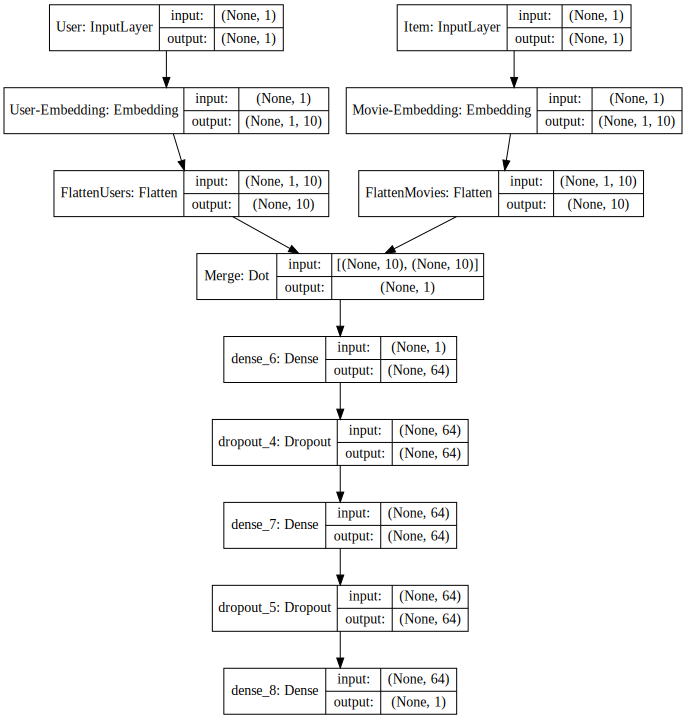

In [40]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [35]:
pred3 = model.predict([ratings.userId[231:240], ratings.movieId[231:241]])
print(pred3)

[[4.169638 ]
 [4.6151433]
 [4.3009768]
 [4.3306336]
 [4.055228 ]
 [3.7233238]
 [3.6798313]
 [4.056531 ]
 [4.3785114]]


In [52]:
pred3 = model.predict([ratings.userId[[2]], ratings.movieId[[28]]])
print(pred3)
pred4 = model.predict([[3], [298]])
print(pred4)
print(ratings.userId[[2]])

[[4.8327813]]
[[0.9392793]]
2    0
Name: userId, dtype: int64


In [24]:
print(ratings.loc[ratings.rating < 2.0])

        userId  movieId  rating   timestamp
205          0      205     1.0   964983504
261          2      259     0.5  1306463578
262          2       28     0.5  1306464275
263          2      260     0.5  1306463619
264          2      261     0.5  1306464228
265          2      262     0.5  1306463595
267          2      264     0.5  1306463567
268          2      265     0.5  1306463627
269          2      266     0.5  1306464216
270          2      267     0.5  1306463569
271          2      268     0.5  1306463624
273          2      269     0.5  1306464189
276          2      120     0.5  1306464175
277          2      271     0.5  1306463572
278          2      128     0.5  1306464261
281          2      273     0.5  1306464293
284          2      276     0.5  1306463638
286          2      277     0.5  1306464245
288          2      279     0.5  1306464284
293          2      284     0.5  1306464204
299          2      290     0.5  1306464164
308          3      298     1.0 